In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision

In [0]:
import numpy as np
import gzip
import struct
import pickle
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import transforms

In [363]:
import urllib.request

urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "train_features.gz")
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "test_features.gz")


def get_features(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
def plot_image(image):
    plt.imshow(image.reshape((28,28)), cmap="gray")
    
features = get_features("train_features.gz").reshape((100,600,784)) / 255
features = torch.from_numpy(features).float().cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


In [0]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout2d()
    
    #encoder
    self.e_fc1 = nn.Linear(784,400)
    self.e_fc2 = nn.Linear(400,200)
    self.e_fc3 = nn.Linear(200,100)
    
    #decoder
    
    self.d_fc1 = nn.Linear(100,400)
    self.d_fc2 = nn.Linear(400,784)
    
  
  def forward(self, input, generating=False):
    # encoding
    mean, var = None, None
    if not generating: 
      res = self.relu(self.e_fc1(input))
      res = self.relu(self.e_fc2(res))
      mean = self.relu(self.e_fc3(res))
      samples = torch.randn_like(mean)
      input = mean + samples
    
    # decoding
    res = self.relu(self.d_fc1(input))
    res = self.sigmoid(self.d_fc2(res))
    return (res,mean)

In [0]:
net = VAE().cuda()

In [0]:
epochs = 200
optimizer = optim.Adam(net.parameters())

def loss_function(recon_x, x, mu):
    RL = ((x - recon_x) ** 2).sum()
    KLD = 0.5 * torch.sum(mu.pow(2))

    return RL + KLD

for i in range(epochs):
  for j in range(10):
    data = features[j,:,:]
    optimizer.zero_grad()
    generated, mean = net(data)
    loss = loss_function(generated, data, mean)
    loss.backward()
    optimizer.step()
#     print("epoch: ", i)
#     print("loss: ", loss)
#     print("reconstruct loss: ", loss_reconstruct.item())
#     print("KL: ", loss_KL.item())
#     print("___________")

In [0]:
from matplotlib import pyplot as plt
def plot_image(image):
    plt.imshow(image.detach().cpu().numpy().reshape((28,28)) * 255, cmap="gray")

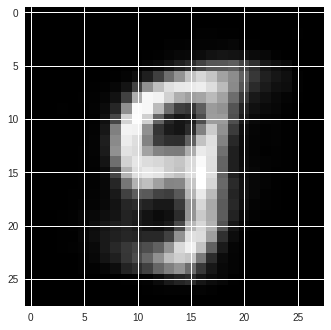

In [459]:
sample = net(torch.randn(1, 100).cuda(), generating=True)[0]
plot_image(sample)